In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K
import os
import keras
from keras.optimizers import Adam
from keras.utils import normalize
from UNet_func_of_blocks import build_unet
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from astropy.io import fits
import glob
from skimage.measure import label, regionprops
from skimage import measure
import random
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import label, find_objects
import scipy.io as sio

2025-02-07 15:18:08.404936: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-07 15:18:08.412168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-07 15:18:08.420736: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-07 15:18:08.423238: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-07 15:18:08.429678: I tensorflow/core/platform/cpu_feature_guar

# Optimal Model Loading...

In [2]:
folder_name = f'E_Loaded_model_120' # 
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created successfully.")
else:
    print(f"Folder '{folder_name}' already exists.")

current_path = os.getcwd()
model_path = os.path.join(current_path, "MODELS_Emask_120_epochs/model_checkpoint_epoch_58.h5.keras")
loaded_model = tf.keras.models.load_model(model_path)

Folder 'E_Loaded_model_120' already exists.


I0000 00:00:1738966689.799806   14012 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738966689.821681   14012 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738966689.823205   14012 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738966689.825905   14012 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [3]:
# Show the model architecture
loaded_model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ activation_4[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ activation_5[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[

 Total params: 93,091,781 (355.12 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,061,188 (236.74 MB)

# DATASET Directory 


In [4]:
parent_dir = os.getcwd()
img_dir = f"{parent_dir}/NewImages/GONG/"
mask_dir = f"{parent_dir}/NewMasks/EUV/"
stereo_dir = f"{parent_dir}/NewImages/EUV/"
file_pattern = '*.fits'

In [5]:
## List all the fits files
fits_files = [file for file in os.listdir(img_dir) if file.endswith(".fits")]
fits_files = sorted(fits_files)

print(fits_files)

['GONG20110212t1200.fits', 'GONG20110213t0000.fits', 'GONG20110213t1200.fits', 'GONG20110214t0000.fits', 'GONG20110214t1200.fits', 'GONG20110215t0000.fits', 'GONG20110215t1200.fits', 'GONG20110218t0000.fits', 'GONG20110218t1200.fits', 'GONG20110219t0000.fits', 'GONG20110219t1200.fits', 'GONG20110220t0000.fits', 'GONG20110220t1200.fits', 'GONG20110221t1200.fits', 'GONG20110222t0000.fits', 'GONG20110222t1200.fits', 'GONG20110223t0000.fits', 'GONG20110223t1200.fits', 'GONG20110224t0000.fits', 'GONG20110224t1200.fits', 'GONG20110225t0000.fits', 'GONG20110225t1200.fits', 'GONG20110226t0000.fits', 'GONG20110226t1200.fits', 'GONG20110227t0000.fits', 'GONG20110227t1200.fits', 'GONG20110228t0000.fits', 'GONG20110228t1200.fits', 'GONG20110301t0000.fits', 'GONG20110301t1200.fits', 'GONG20110302t0000.fits', 'GONG20110302t1200.fits', 'GONG20110303t0000.fits', 'GONG20110304t0000.fits', 'GONG20110304t1200.fits', 'GONG20110305t0000.fits', 'GONG20110305t1200.fits', 'GONG20110306t0000.fits', 'GONG201103

# Dataset Prep

In [6]:
image_stack = []
mask_stack = []
stereo_stack = []

file_paths_stereo = glob.glob(stereo_dir + file_pattern)
file_paths_image = glob.glob(img_dir + file_pattern)
file_paths_mask = glob.glob(mask_dir + file_pattern)


file_paths_stereo.sort()
file_paths_image.sort()
file_paths_mask.sort()

# load in the image data
for file_path in file_paths_image:
    data = fits.getdata(file_path)
    image_stack.append(data)

# load in the mask data
for file_path in file_paths_mask:
    data = fits.getdata(file_path)
    mask_stack.append(data)

# load in the STEREO data
for file_path in file_paths_stereo:
    data = fits.getdata(file_path)
    stereo_stack.append(data)
    
stereo_stack = np.array(stereo_stack)
image_stack = np.array(image_stack)
mask_stack = np.array(mask_stack)

if mask_stack.shape == image_stack.shape:
    print("Image and mask stacks have the same shape")
else:
    exit("Image and mask stacks do not have the same shape")

# reduce the image dimensions 
image_stack = image_stack.reshape(-1, image_stack.shape[1], image_stack.shape[2])
mask_stack = mask_stack.reshape(-1, mask_stack.shape[1], mask_stack.shape[2])
stereo_stack = stereo_stack.reshape(-1, stereo_stack.shape[1], stereo_stack.shape[2])

#add channel dimension
stereo_stack = np.expand_dims(stereo_stack, axis=-1)
image_stack = np.expand_dims(image_stack, axis=-1)
mask_stack  = np.expand_dims(mask_stack, axis=-1)

# Create an array of indices
indices = np.arange(len(image_stack))

train_indices_path = os.path.join(current_path, "MODELS_Emask_120_epochs/train_indices.npy")
train_indices = np.load(train_indices_path)

test_indices_path = os.path.join(current_path, "MODELS_Emask_120_epochs/test_indices.npy")
test_indices = np.load(test_indices_path)

X_train_indices = train_indices
X_test_indices = test_indices

y_train, y_test = mask_stack[train_indices], mask_stack[test_indices]


# Use the indices to access the data 
X_train = image_stack[X_train_indices]
X_test = image_stack[X_test_indices]

stereo_train = stereo_stack[X_train_indices]
stereo_test = stereo_stack[X_test_indices]

print(f"{len(image_stack)} images total")
print(f"{len(mask_stack)} masks loaded")
print(f"{len(stereo_stack)} stereo loaded")

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

Image and mask stacks have the same shape
2381 images total
2381 masks loaded
2381 stereo loaded
X_train shape: (1785, 256, 256, 1)
X_test shape: (596, 256, 256, 1)


In [7]:
FitsFiles_train = [fits_files[i] for i in X_train_indices]
FitsFiles_test = [fits_files[i] for i in X_test_indices]

## Probability Map

I0000 00:00:1738966693.904046   14432 service.cc:146] XLA service 0x733f00003b10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738966693.904060   14432 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2025-02-07 15:18:13.912938: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-07 15:18:14.110665: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2025-02-07 15:18:20.937043: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 17.56GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-02-07 15:18:21.988189: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] A

 3/19 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step

I0000 00:00:1738966706.622916   14432 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step

2025-02-07 15:18:33.614437: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 17.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-02-07 15:18:34.316657: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 17.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-02-07 15:18:35.068915: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 18.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 580ms/step
IoU score is:  0.16349428068485863


2025-02-07 15:18:38.583264: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.57GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-02-07 15:18:38.641601: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.33GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-02-07 15:18:38.714726: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


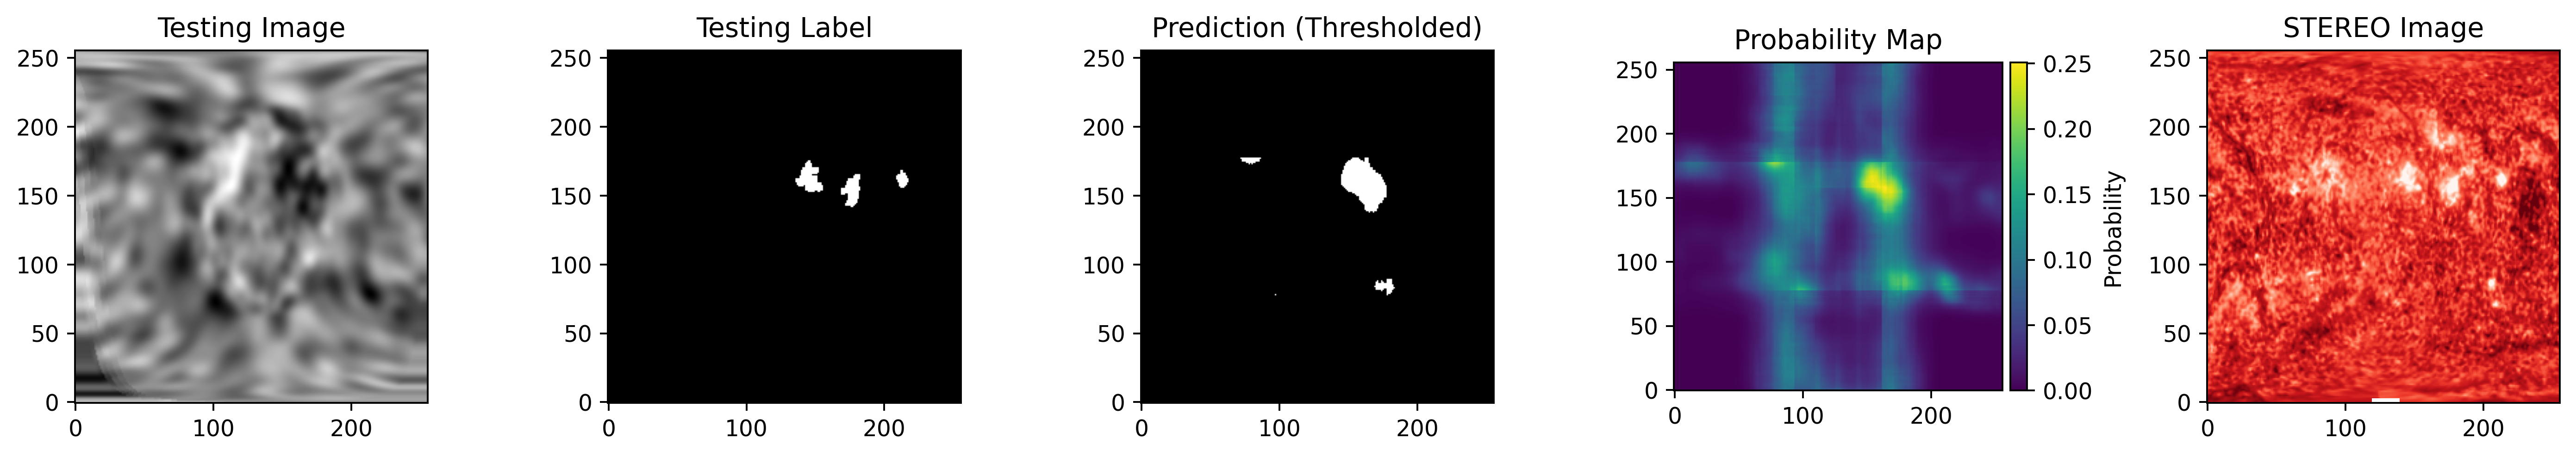

GONG20120306t0000.fits


In [8]:
prop_threshold = 0.17

# Generate a prediction on a single image
y_pred = loaded_model.predict(X_test)  
y_pred_thresholded = y_pred > prop_threshold  

# Intersection over Union (IoU) 
intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU score is: ", iou_score)

# Predict on a randomly selected test image
test_img_number = random.randint(0, len(X_test))
test_img_number = test_img_number
test_img = X_test[test_img_number]
stereo_img = stereo_test[test_img_number]
ground_truth = y_test[test_img_number]

# Normalize and prepare input for prediction
test_img_norm = test_img[:, :, 0][:, :, None]
test_img_input = np.expand_dims(test_img_norm, 0)

# Generate prediction (raw probability map)
probability_map = loaded_model.predict(test_img_input)[0, :, :, 0]

prediction = (probability_map > prop_threshold).astype(np.uint8)

fig = plt.figure(figsize=(16, 8), dpi=350)
gs = GridSpec(1, 5, figure=fig)

# Original Test Image
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title('Testing Image')
ax1.imshow(test_img[:, :, 0], cmap='gray', origin='lower')

# Ground Truth Label
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title('Testing Label')
ax2.imshow(ground_truth[:, :, 0], cmap='gray', origin='lower')

# Prediction after Thresholding
ax3 = fig.add_subplot(gs[0, 2])
ax3.set_title('Prediction (Thresholded)')
ax3.imshow(prediction, cmap='gray', origin='lower')

# Probability Map (Raw Model Output)
ax4 = fig.add_subplot(gs[0, 3])
ax4.set_title('Probability Map')
im = ax4.imshow(probability_map, cmap='viridis', origin='lower')
divider = make_axes_locatable(ax4)
cax = divider.append_axes("right", size="5%", pad=0.05)  # Adjust size and padding of the colorbar
fig.colorbar(im, cax=cax, label='Probability')

# STEREO Image
ax5 = fig.add_subplot(gs[0, 4])
ax5.set_title('STEREO Image')
stereo = ax5.imshow(stereo_img, cmap='Reds_r', origin='lower')
stereo.set_clim(-2, 4)  # Set color limits directly on the image object

plt.tight_layout()
plt.show()
print(FitsFiles_test[test_img_number])

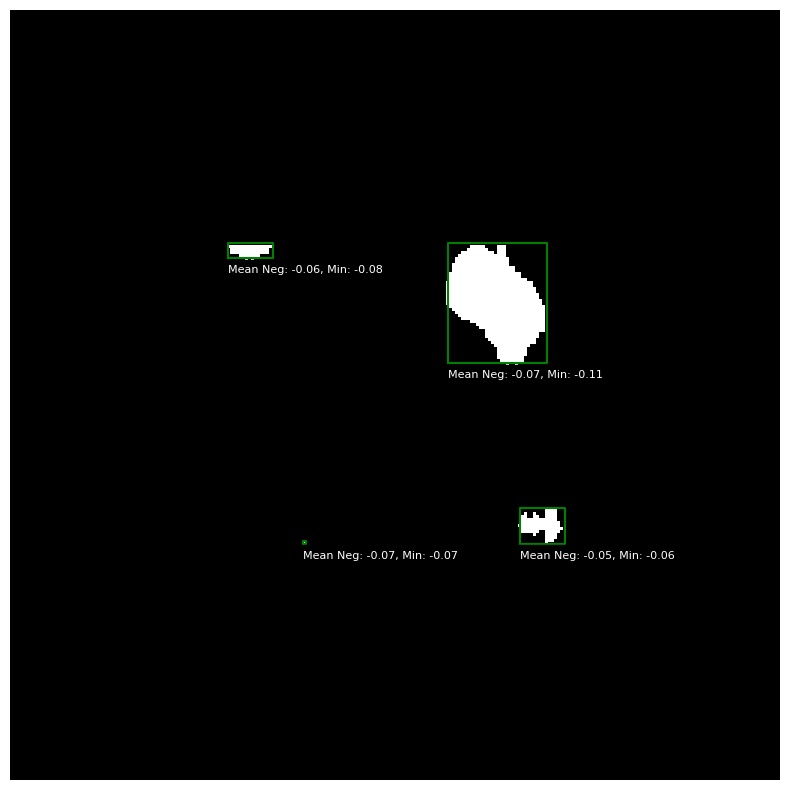

In [9]:
labeled_array, num_features = label(prediction)
bounding_boxes = find_objects(labeled_array)

# Plot the prediction map
plt.figure(figsize=(10, 10))
plt.imshow(prediction, cmap='gray', origin='lower')

# Loop through each isolated region
for i, box in enumerate(bounding_boxes):
    y_min, y_max = box[0].start, box[0].stop
    x_min, x_max = box[1].start, box[1].stop

    region_mask = (labeled_array == i + 1)
    region_values = test_img[region_mask]
    
    # Filter for negative values only
    negative_values = region_values[region_values < 0]
    
    # Calculate mean of negative values (if any) within the region
    if negative_values.size > 0:
        mean_neg_val = np.mean(negative_values)
    else:
        mean_neg_val = np.nan  
    
    # Calculate minimum of all values within the region
    min_val = np.min(region_values)
    
    # Draw the bounding box as a green rectangle
    plt.plot([x_min, x_max, x_max, x_min, x_min],
             [y_min, y_min, y_max, y_max, y_min], color="green")

    # Display mean of negative values and minimum value above the bounding box
    plt.text(x_min, y_min - 5, f"Mean Neg: {mean_neg_val:.2f}, Min: {min_val:.2f}", 
             color="white", fontsize=8, backgroundcolor="black")

plt.axis('off')
plt.show()


## Evaluation metrices

In [10]:
# Define the custom IoU metric
def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.2, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + K.epsilon())  # Add epsilon to avoid division by zero

# Define custom Precision metric
def precision_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.2, tf.float32)
    true_positives = tf.reduce_sum(y_true * y_pred)
    predicted_positives = tf.reduce_sum(y_pred)
    return true_positives / (predicted_positives + K.epsilon())

# Define custom Recall metric
def recall_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.2, tf.float32)
    true_positives = tf.reduce_sum(y_true * y_pred)
    actual_positives = tf.reduce_sum(y_true)
    return true_positives / (actual_positives + K.epsilon())

# Define custom F1 Score metric
def f1_metric(y_true, y_pred):
    precision = precision_metric(y_true, y_pred)
    recall = recall_metric(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# Compile the model with all metrics
loaded_model.compile(optimizer=Adam(learning_rate=0.001), 
                     loss='binary_crossentropy', 
                     metrics=['accuracy', iou_metric, precision_metric, recall_metric, f1_metric])

# Evaluate the model again
results = loaded_model.evaluate(X_test, y_test, verbose=1)

# Print the results
print(f"Loss: {results[0]}")
print(f"Accuracy: {results[1]}")
print(f"IoU: {results[2]}")
print(f"Precision: {results[3]}")
print(f"Recall: {results[4]}")
print(f"F1 Score: {results[5]}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.9557 - f1_metric: 0.2405 - iou_metric: 0.1369 - loss: 0.1559 - precision_metric: 0.5042 - recall_metric: 0.1586
Loss: 0.15448448061943054
Accuracy: 0.9566019773483276
IoU: 0.13209544122219086
Precision: 0.49927404522895813
Recall: 0.15275931358337402
F1 Score: 0.23298519849777222


In [11]:
# Define thresholds to test
thresholds = np.arange(0.0, 1.0, 0.05)

best_threshold = 0.0
best_dice_score = 0.0 

for threshold in thresholds:
    y_pred_thresholded = (y_pred > threshold).astype(np.float32)
    
    intersection = np.sum(y_test * y_pred_thresholded)
    union = np.sum(y_test) + np.sum(y_pred_thresholded)
    dice_score = 2 * intersection / (union + 1e-6)  # Add small epsilon to avoid division by zero

    if dice_score > best_dice_score:
        best_dice_score = dice_score
        best_threshold = threshold

print(f"Optimal Threshold: {best_threshold}, Best Dice Score: {best_dice_score}")

Optimal Threshold: 0.15000000000000002, Best Dice Score: 0.29405004880636704


## Code to Plot the ROC Curve


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step


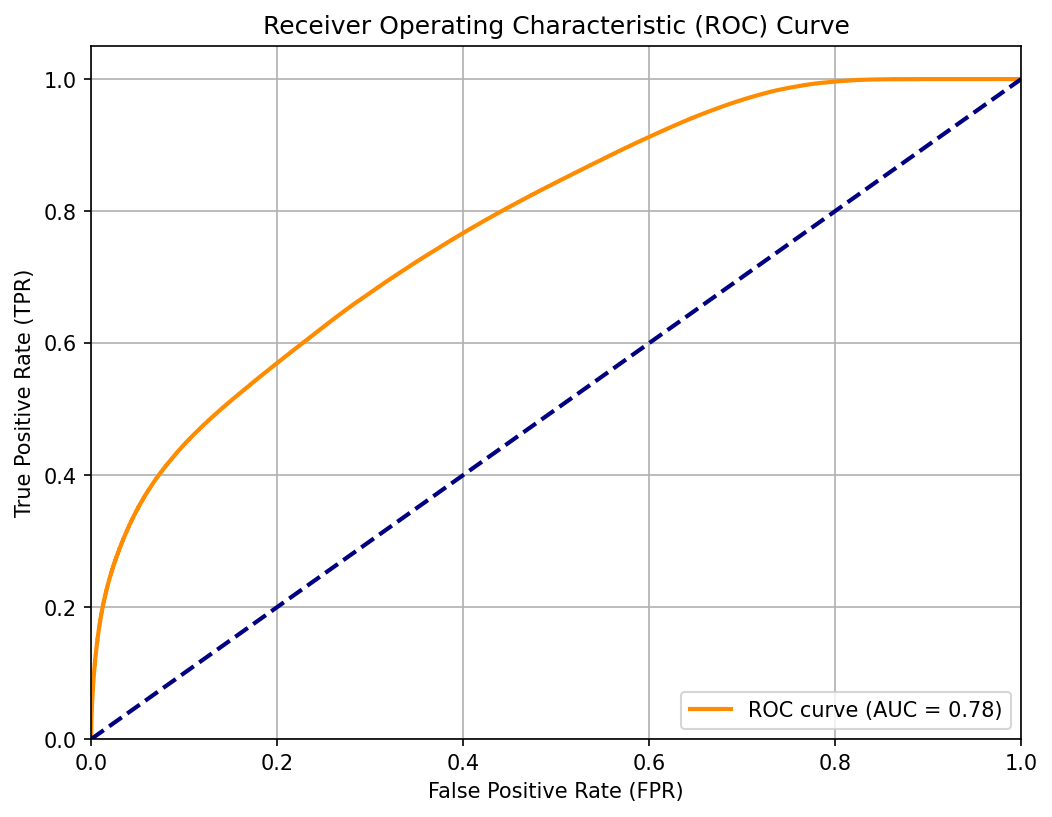

Training history saved to E_Loaded_model_120/ROC_curve.mat
AUC: 0.7794


In [12]:
y_pred = loaded_model.predict(X_test)  
y_pred_flat = y_pred.flatten()  

y_test_flat = y_test.flatten()

fpr, tpr, thresholds = roc_curve(y_test_flat, y_pred_flat)
roc_auc = auc(fpr, tpr)

# Plotting the ROC Curve
plt.figure(figsize=(8, 6), dpi=150)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
file_name = f"ROC.png"  
plt.savefig(f'{folder_name}/{file_name}', bbox_inches='tight') 
plt.show()

ROC_mat_filepath = os.path.join(folder_name, 'ROC_curve.mat')

ROC_data = {
    'fpr': fpr,
    'tpr': tpr,
    'AUC': roc_auc
}

sio.savemat(ROC_mat_filepath, ROC_data)
print(f"Training history saved to {ROC_mat_filepath}")
print(f"AUC: {roc_auc:.4f}")

## the Precision-Recall Curve

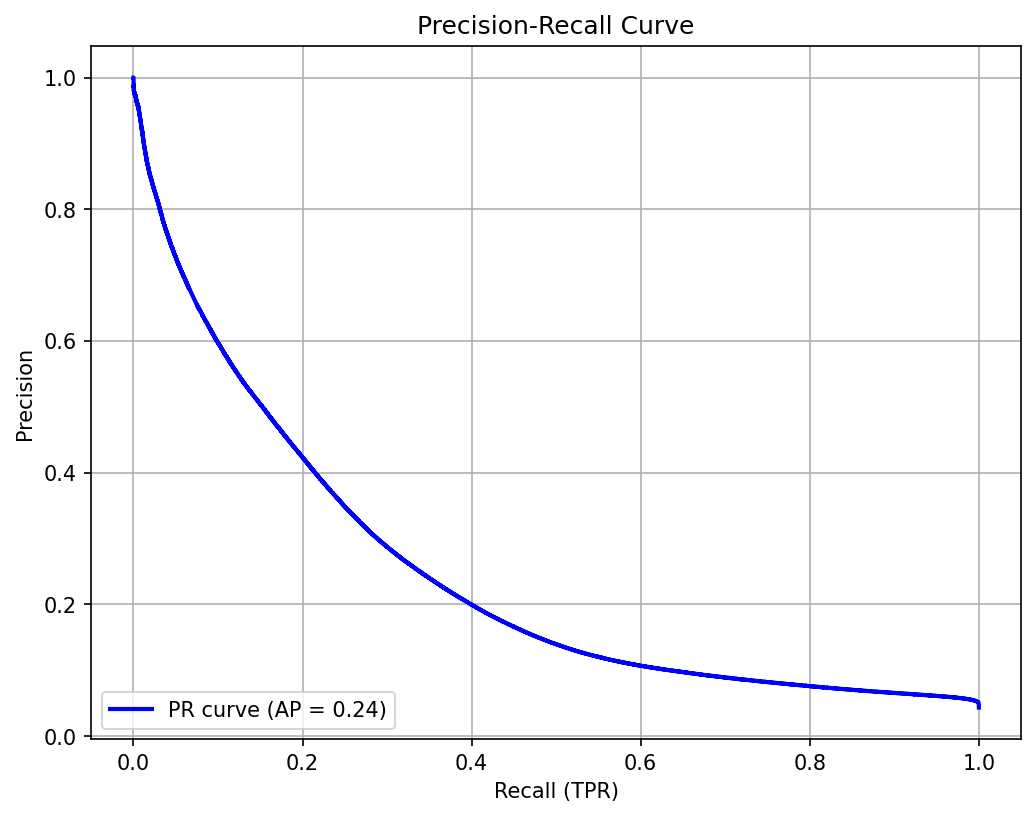

Training history saved to E_Loaded_model_120/Rprecision_recall_curve.mat
AP: 0.2445


In [13]:
precision, recall, thresholds = precision_recall_curve(y_test_flat, y_pred_flat)
average_precision = average_precision_score(y_test_flat, y_pred_flat)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6), dpi=150)
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {average_precision:.2f})')
plt.xlabel('Recall (TPR)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
file_name = f"PR.png"  
plt.savefig(f'{folder_name}/{file_name}', bbox_inches='tight') 
plt.show()

precision_recall_curve_mat_filepath = os.path.join(folder_name, 'Rprecision_recall_curve.mat')


precision_recall_data = {
    'recall': recall,
    'precision': precision,
    'AP': average_precision
}

sio.savemat(precision_recall_curve_mat_filepath, precision_recall_data)
print(f"Training history saved to {precision_recall_curve_mat_filepath}")
print(f"AP: {average_precision:.4f}")